<a href="https://colab.research.google.com/github/blkeyd/CVPR/blob/main/alexnet_firedetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Image transformation

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

Dataset Split

In [ ]:
import os
import shutil
import random

source_dir = "/content/drive/MyDrive/fire_dataset"
target_dir = "/content/drive/MyDrive/fire_dataset_split"

classes = ["fire", "nofire"]
split_ratio = [0.7, 0.15, 0.15]  # train, val, test

# Create folders
for split in ["train", "val", "test"]:
    for cls in classes:
        os.makedirs(os.path.join(target_dir, split, cls), exist_ok=True)

# Split files
for cls in classes:
    cls_path = os.path.join(source_dir, cls)
    images = os.listdir(cls_path)
    random.shuffle(images)

    total = len(images)
    train_end = int(total * split_ratio[0])
    val_end = train_end + int(total * split_ratio[1])

    train_imgs = images[:train_end]
    val_imgs = images[train_end:val_end]
    test_imgs = images[val_end:]

    for img in train_imgs:
        shutil.copy(os.path.join(cls_path, img),
                    os.path.join(target_dir, "train", cls, img))

    for img in val_imgs:
        shutil.copy(os.path.join(cls_path, img),
                    os.path.join(target_dir, "val", cls, img))

    for img in test_imgs:
        shutil.copy(os.path.join(cls_path, img),
                    os.path.join(target_dir, "test", cls, img))

print("Dataset successfully split into train / val / test")

Dataset successfully split into train / val / test


Load Dataset

In [ ]:
data_dir = "/content/drive/MyDrive/fire_dataset_split"

train_data = datasets.ImageFolder(data_dir + "/train", transform=transform)
val_data   = datasets.ImageFolder(data_dir + "/val", transform=transform)
test_data  = datasets.ImageFolder(data_dir + "/test", transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_data, batch_size=32, shuffle=False)

class_names = train_data.classes
print(class_names)   # ['fire', 'nofire']

['fire', 'nofire']


Load AlexNet

In [ ]:
model = models.alexnet(pretrained=True)

# Modify last layer for 2 classes
model.classifier[6] = nn.Linear(4096, 2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:01<00:00, 167MB/s]


Loss and Optimizer

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

Training Loop

In [ ]:
def train_model(model, train_loader, val_loader, epochs=10):
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = 100 * correct / total

        # Validation
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_acc = 100 * val_correct / val_total

        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Train Loss: {train_loss/len(train_loader):.4f} "
              f"Train Acc: {train_acc:.2f}% "
              f"Val Acc: {val_acc:.2f}%")


Run Training

In [ ]:
train_model(model, train_loader, val_loader, epochs=10)

Epoch [1/10] Train Loss: 0.1399 Train Acc: 93.57% Val Acc: 98.94%
Epoch [2/10] Train Loss: 0.0242 Train Acc: 99.45% Val Acc: 98.94%
Epoch [3/10] Train Loss: 0.0103 Train Acc: 99.89% Val Acc: 99.29%
Epoch [4/10] Train Loss: 0.0006 Train Acc: 100.00% Val Acc: 99.29%
Epoch [5/10] Train Loss: 0.0001 Train Acc: 100.00% Val Acc: 99.29%
Epoch [6/10] Train Loss: 0.0001 Train Acc: 100.00% Val Acc: 99.29%
Epoch [7/10] Train Loss: 0.0000 Train Acc: 100.00% Val Acc: 99.29%
Epoch [8/10] Train Loss: 0.0001 Train Acc: 100.00% Val Acc: 98.94%
Epoch [9/10] Train Loss: 0.0000 Train Acc: 100.00% Val Acc: 98.94%
Epoch [10/10] Train Loss: 0.0000 Train Acc: 100.00% Val Acc: 99.29%


Testing Accuracy

In [ ]:
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Test Accuracy: {100 * correct / total:.2f}%")


In [ ]:
test_model(model, test_loader)

Test Accuracy: 99.29%


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:\n", cm)
    print("\nClassification Report:\n",
          classification_report(all_labels, all_preds, target_names=class_names))

evaluate_model(model, test_loader)



Confusion Matrix:
 [[208   2]
 [  0  70]]

Classification Report:
               precision    recall  f1-score   support

        fire       1.00      0.99      1.00       210
      nofire       0.97      1.00      0.99        70

    accuracy                           0.99       280
   macro avg       0.99      1.00      0.99       280
weighted avg       0.99      0.99      0.99       280



Confusion Matrix


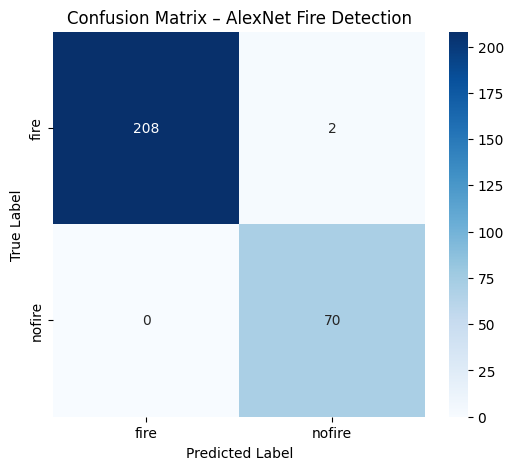

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d',
                xticklabels=class_names,
                yticklabels=class_names,
                cmap='Blues')
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix – AlexNet Fire Detection")
    plt.show()

plot_confusion_matrix(model, test_loader)

ROC Curve

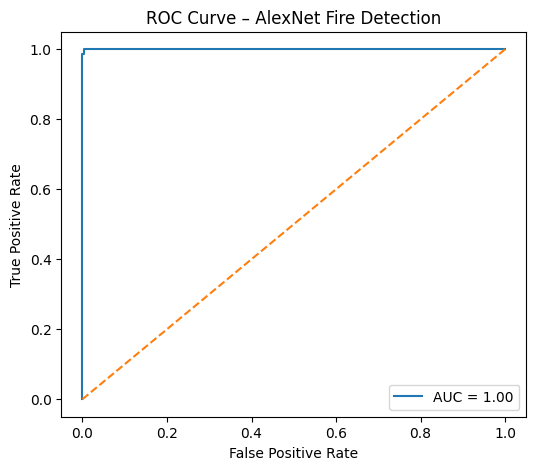

In [ ]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(model, test_loader):
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            probs = torch.softmax(outputs, dim=1)
            all_probs.extend(probs[:, 1].cpu().numpy())  # probability of "fire"
            all_labels.extend(labels.cpu().numpy())

    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0,1], [0,1], linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve – AlexNet Fire Detection")
    plt.legend()
    plt.show()

plot_roc_curve(model, test_loader)